In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf

/Users/kobayashitomohiro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/kobayashitomohiro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
def model_inputs(real_dim, z_dim):
    input_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return input_real, input_z

In [14]:
def generator(z, out_dim, n_units=128, reuse=False,alpha=0.01 ):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1 , h1) #LeakyReLU
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [21]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [22]:
#ハイパーパラメータの初期化

input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size=128
alpha=0.01
smooth = 0.1#Dの学習を円滑にする調整１に近づくと学習が進まない

計算グラフの定義
1モデルの定義
２損失関数を定義（G、D）
３最適手法の定義

In [24]:
#グラフの定義を行う
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units = d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha,n_units=d_hidden_size)

損失関数の定義

In [28]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                    labels=tf.ones_like(d_logits_real)*(1-smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels = tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))

最適化

In [43]:
#最適化の定義
learning_rate=0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

バッチデータ

In [32]:
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [33]:
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([3, 4, 2, 0, 0, 5, 4, 8, 0, 0, 0, 8, 6, 2, 4, 3, 0, 9, 1, 4, 6, 1,
        8, 9, 7, 4, 8, 4, 0, 3, 9, 5, 4, 7, 3, 0, 6, 2, 1, 8, 6, 9, 9, 3,
        3, 0, 9, 5, 6, 9, 8, 8, 1, 0, 1, 8, 1, 7, 0, 2, 7, 5, 8, 0, 3, 6,
        7, 0, 0, 7, 0, 8, 2, 4, 9, 8, 0, 0, 6, 6, 8, 8, 7, 2, 7, 6, 7, 5,
        8, 9, 2, 8, 4, 2, 9, 6, 6, 0, 1, 9], dtype=uint8))

In [34]:
batch[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
len(batch[0])

100

In [36]:
len(batch[0][0])

784

In [38]:
batch[1][0]

3

トレーニングの実行

In [46]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape(batch_size, 784)
            batch_images = batch_images * 2 -1 #0~1->-1~1に変換
            
            #Generator
            batch_z = np.random.uniform(-1,1,size = (batch_size, z_size))
            
            _ = sess.run(d_train_optimize, feed_dict={input_real: batch_images, input_z: batch_z})
            _= sess.run(g_train_optimize, feed_dict = {input_z:batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("エポック {}/{}".format(e+1, epochs),
        "D ロス: {:.4f}".format(train_loss_d),
        "G ロス: {:.4f}".format(train_loss_g))
        
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1,1,size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size,
                                         reuse=True, alpha=alpha), feed_dict = {input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/genetator.ckpt')
        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

エポック 1/100 D ロス: 0.3757 G ロス: 3.4056
エポック 2/100 D ロス: 0.3933 G ロス: 3.5561
エポック 3/100 D ロス: 0.6414 G ロス: 5.0322
エポック 4/100 D ロス: 1.2384 G ロス: 2.0092
エポック 5/100 D ロス: 1.1503 G ロス: 2.6992
エポック 6/100 D ロス: 3.2092 G ロス: 1.8403
エポック 7/100 D ロス: 0.5473 G ロス: 2.9018
エポック 8/100 D ロス: 1.3826 G ロス: 1.5834
エポック 9/100 D ロス: 1.4131 G ロス: 1.6986
エポック 10/100 D ロス: 1.3603 G ロス: 1.7483
エポック 11/100 D ロス: 1.5294 G ロス: 1.8700
エポック 12/100 D ロス: 1.3793 G ロス: 1.1277
エポック 13/100 D ロス: 1.8084 G ロス: 1.7306
エポック 14/100 D ロス: 1.3027 G ロス: 1.6468
エポック 15/100 D ロス: 1.2737 G ロス: 1.3384
エポック 16/100 D ロス: 1.0487 G ロス: 1.5828
エポック 17/100 D ロス: 1.0972 G ロス: 1.4616
エポック 18/100 D ロス: 1.2929 G ロス: 2.0998
エポック 19/100 D ロス: 1.1788 G ロス: 1.1844
エポック 20/100 D ロス: 2.7305 G ロス: 1.5879
エポック 21/100 D ロス: 1.0345 G ロス: 1.9695
エポック 22/100 D ロス: 0.9971 G ロス: 1.9846
エポック 23/100 D ロス: 1.5296 G ロス: 1.5549
エポック 24/100 D ロス: 0.8802 G ロス: 1.9845
エポック 25/100 D ロス: 1.4005 G ロス: 1.6486
エポック 26/100 D ロス: 1.1075 G ロス: 2.2197
エポック 27/100 D ロス: 0.8

収束プロセスの可視化

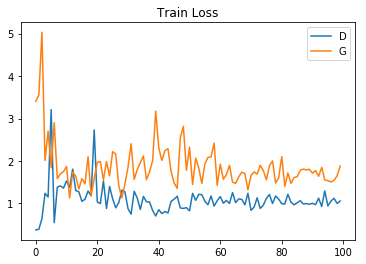

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0], label="D")
plt.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

イメージに変換して表示する

In [65]:
def view_samples(epoch, samples):
    fig, axes =plt.subplots(figsize=(7,7), ncols=4,nrows=4, sharey=True, sharex=True)
    for ax,img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    return fig, axes

In [66]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

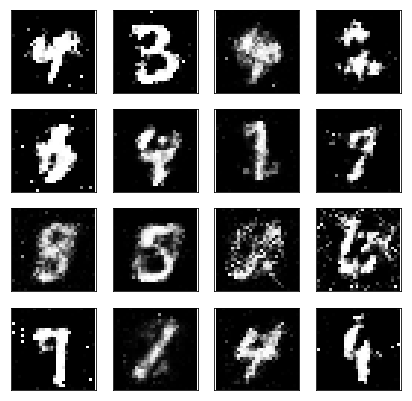

In [72]:
_ = view_samples(98, samples)

TypeError: object of type 'numpy.float32' has no len()

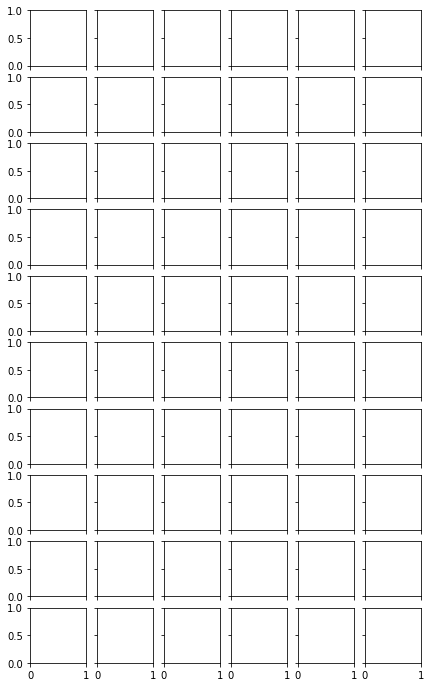

In [85]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols = cols, sharex = True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape(28,28), cmap="Greys_r")
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [ ]:
type(sample)

チェックポイントファイルから機械に画像を生成させる

INFO:tensorflow:Restoring parameters from checkpoints/genetator.ckpt


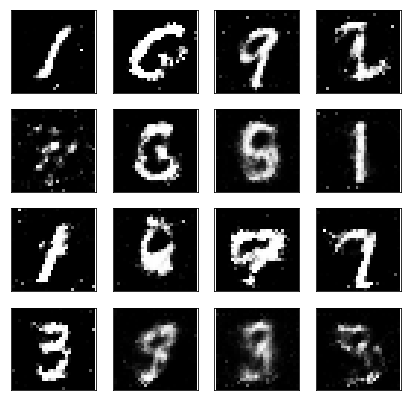

In [90]:
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1,size=(16,z_size))
    gen_samples = sess.run(generator(input_z,input_size, n_units=g_hidden_size,reuse=True,
                                    alpha=alpha),feed_dict={input_z:sample_z})
_= view_samples(0, [gen_samples])